# BL General Analytics Exam

## Background

You are a health insurance company with a monopoly on health insurance in the state of
Texas. Everyone in Texas either has an insurance plan through your company, or they are
uninsured. You have access to health insurance plan status and corresponding demographic
data for 10,000 Texas residents. You also have county-level demographic profiles and
insurance rates for the entire state.

## Objective

 1. What types of people tend to be insured, and what types of people tend to be uninsured? Please present your findings. Feel free to use a combination of prose, tables or graphs/visualizations.
 
 2. Separately, 2 of your colleagues are disagreeing. One says Latinos are less likely to be insured, the other says that people with lower educations are less likely to be  insured. How would you explain your best answer to this question?
 
3. Pick only one of the three modes available ( information below ). Given a $50,000 budget, design an outreach strategy to expand your customer base across Texas. The goal is to reach as many uninsured consumers as possible. Please identify your assumptions.

4. You are told that there will be more budget to spend on outreach in 2 months; make a
plan to add a new mode. How would you allocate between the two modes?

5. You are also given a smaller budget to spend in the meantime in order to inform your
plan of which mode to add? What tests would you run to help inform your allocation
plan?

### Exploratory Analysis and Data Cleaning

In [916]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

sns.set_theme()
pd.set_option('display.max_columns', None)

plt.rcParams["figure.figsize"] = (12, 6)

In [1017]:
resident_df = pd.read_csv('data_day_sample_20180410_export.csv', skipfooter = 1, engine = 'python')
resident_df.head()

,id,state,county_name,media_market,gender,political_party,education_area,age,gender_female,gender_male,income,maritalstatus_single,maritalstatus_married,length_of_residence,has_children,number_of_children,is_homeowner,is_renter,level_of_education,religion_catholic,religion_christian,donor_political_org,donor_liberal_org,donor_conservative_org,donor_religious_org,donor_health_org,occupation_blue_collar,occupation_farmer,occupation_professional_technical,occupation_retired,purchases_apparel,purchases_book,purchases_electronic,purchases_boat,purchases_luxuryitems,has_a_cat,interests_environment,interests_outdoorgarden,interests_outdoorsport,interests_guns,interests_golf,interests_investing,interests_veteranaffairs,ethnicity_afam,ethnicity_latino,ethnicity_asian,ethnicity_white,ethnicity_other,health_insurance
0,2b79fa61dab4f25a68e6143da260b62d,TX,midland,odessa-midland tx,F,R,03-Low Education Area,36,1,0,112,0,1,25.0,1,2,1,0,no hs degree,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Health Insurance Plan Blue
1,9f1226559658a9b83e2d8f2eadd9d9d6,TX,bexar,san antonio tx,M,D,03-Low Education Area,28,0,1,20,0,1,19.0,0,0,1,0,no hs degree,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Health Insurance Plan Blue
2,ec7dda6179018d844bd101fe72c83515,TX,victoria,victoria tx,F,I,03-Low Education Area,29,1,0,30,0,1,3.0,1,0,1,0,no hs degree,1,0,1,0,0,0,0,1,0,0,0,1,1,1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,Health Insurance Plan Blue
3,e2055749e26a483b6bd8fd18e4b2fec3,TX,gillespie,austin tx,M,R,02-Medium Education Area,38,0,1,87,0,1,15.0,1,4,1,0,some college,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,1,1,0,1,0,0,0,0,1,0,Health Insurance Plan Red
4,6251d9b7f3e2788c316982cc48a49e5c,TX,bexar,san antonio tx,F,D,03-Low Education Area,21,1,0,62,1,0,11.0,0,0,1,0,no hs degree,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Health Insurance Plan Blue


In [1018]:
#Remove these fields because they are not needed 
resident_df.drop(['id', 'state'], axis = 1, inplace = True)

In [1019]:
resident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   county_name                        10000 non-null  object 
 1   media_market                       10000 non-null  object 
 2   gender                             10000 non-null  object 
 3   political_party                    10000 non-null  object 
 4   education_area                     10000 non-null  object 
 5   age                                10000 non-null  int64  
 6   gender_female                      10000 non-null  int64  
 7   gender_male                        10000 non-null  int64  
 8   income                             10000 non-null  int64  
 9   maritalstatus_single               10000 non-null  int64  
 10  maritalstatus_married              10000 non-null  int64  
 11  length_of_residence                9775 non-null   floa

In [1020]:
print(f"There are {resident_df.length_of_residence.isnull().sum()} missing values in the length_of_residence field")
print('\n')
print(f"There are {len(resident_df.query('length_of_residence == 0'))} records with a 0 in the length_of_residence field")
print('\n')

There are 225 missing values in the length_of_residence field


There are 627 records with a 0 in the length_of_residence field




**Observation** : The nulls in length_of_residence do not refer to residents who have lived in that location for less than a year. If that were the case, I'd expect to see 0 as a response,
therefore these must be missing values. The values and associated records will be dropped and not imputed because they make up only 2.25% of the data. 

In [1021]:
resident_df=resident_df.dropna(axis = 0, how ='any')

In [1022]:
#This is the target variable
resident_df.health_insurance.value_counts(normalize=True)

Health Insurance Plan Blue    0.605831
Health Insurance Plan Red     0.264246
Uninsured                     0.129923
Name: health_insurance, dtype: float64

**Observation** : Even though the client is a monopoly it offers two different plans in Texas. 
For the sake of simplicity I will create a new variable that classifies holders of either plan as insured.
<br>
Also, the classes are very imbalanced, ~ 80% of residents have insurance. This will be corrected later for the model.

In [1023]:
resident_df['health_insurance_binary'] = np.where(resident_df['health_insurance'] != 'Uninsured', '1', '0').astype('int64')

In [1024]:
resident_df.groupby('health_insurance_binary').mean()

,age,gender_female,gender_male,income,maritalstatus_single,maritalstatus_married,length_of_residence,has_children,number_of_children,is_homeowner,is_renter,religion_catholic,religion_christian,donor_political_org,donor_liberal_org,donor_conservative_org,donor_religious_org,donor_health_org,occupation_blue_collar,occupation_farmer,occupation_professional_technical,occupation_retired,purchases_apparel,purchases_book,purchases_electronic,purchases_boat,purchases_luxuryitems,has_a_cat,interests_environment,interests_outdoorgarden,interests_outdoorsport,interests_guns,interests_golf,interests_investing,interests_veteranaffairs,ethnicity_afam,ethnicity_latino,ethnicity_asian,ethnicity_white,ethnicity_other
health_insurance_binary,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,40.807087,0.561417,0.438583,84.343307,0.182677,0.813386,11.244094,0.755118,0.651181,0.897638,0.051181,0.274016,0.036220,0.270079,0.021260,0.004724,0.013386,0.046457,0.259055,0.004724,0.174016,0.032283,0.305512,0.423622,0.553543,0.065354,0.359843,0.091339,0.370866,0.422047,0.348031,0.140157,0.121260,0.368504,0.011024,0.158268,0.375591,0.020472,0.445669,0.000000
1,43.137566,0.526631,0.472898,89.229159,0.182481,0.812463,10.748266,0.729453,0.583657,0.843504,0.121458,0.204115,0.041623,0.290653,0.026102,0.008466,0.018812,0.049030,0.241623,0.004468,0.219400,0.025514,0.337566,0.440329,0.548383,0.094650,0.393651,0.110523,0.389183,0.450911,0.370723,0.169900,0.126867,0.388595,0.035156,0.148854,0.248089,0.030218,0.572604,0.000235


**Observations**:
* Both age and income tend to be slightly higher among residents with health insurance.
* Length of residence is slightly higher among the uninsured.
* A higher proportion of white residents are insured when compared to other ethnic groups.

In [1025]:
pd.crosstab(resident_df.gender,resident_df.health_insurance_binary, normalize='index')

health_insurance_binary,0,1
gender,,
F,0.137327,0.862673
M,0.121642,0.878358
U,0.000000,1.000000


<AxesSubplot:xlabel='gender'>

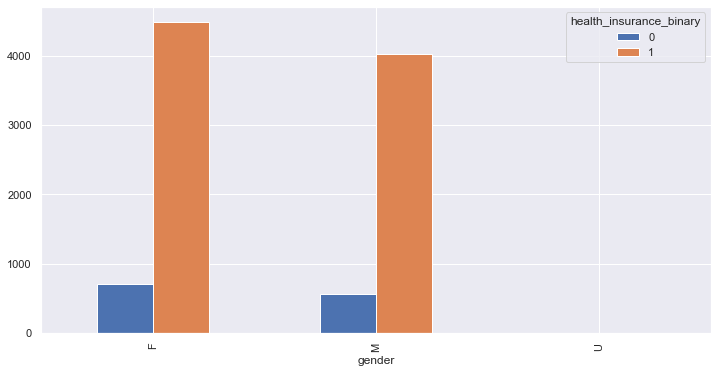

In [1026]:
pd.crosstab(resident_df.gender,resident_df.health_insurance_binary).plot(kind='bar')

**Observation** : Although women make up a larger share of the insured, men are still more likely to have insurance than women. This indicates that being a man might be a predictor of health insurance

<AxesSubplot:xlabel='age'>

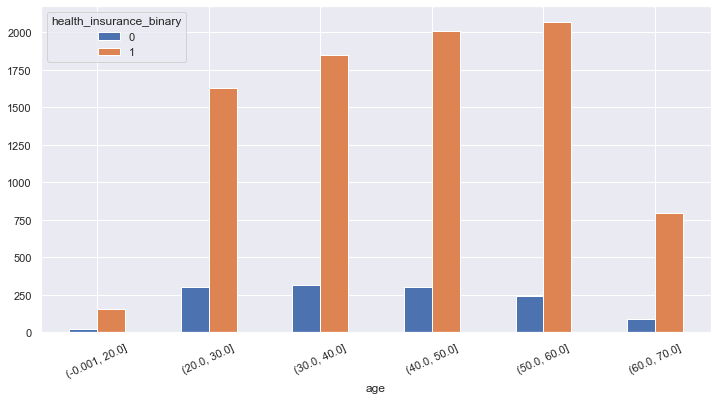

In [1027]:
age_bins = pd.cut(resident_df.age, bins=[0, 20, 30, 40, 50, 60, 70], include_lowest=True)
pd.crosstab(age_bins,resident_df.health_insurance_binary).plot.bar(rot = 25)

**Observation** : Even though the age brackets have similar sizes, enrollment in health insurance rises as age increases.  

<AxesSubplot:xlabel='income'>

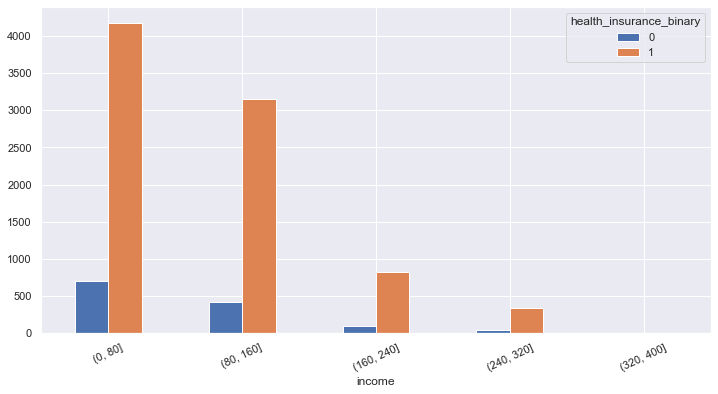

In [1028]:
income_bins = pd.cut(resident_df.income, bins=[0, 80, 160, 240, 320, 400])
pd.crosstab(income_bins,resident_df.health_insurance_binary).plot.bar(rot=25)

**Observation** : Income also seems to be a predictor of health insurace. The more money a resident earns, the lower the enrollment rates.

### Feature Engineering 

In [1029]:
#Do any of the variables appear to have a relationship? Identify colinear variables that might need to be removed or adjusted
resident_df.corr().style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,age,gender_female,gender_male,income,maritalstatus_single,maritalstatus_married,length_of_residence,has_children,number_of_children,is_homeowner,is_renter,religion_catholic,religion_christian,donor_political_org,donor_liberal_org,donor_conservative_org,donor_religious_org,donor_health_org,occupation_blue_collar,occupation_farmer,occupation_professional_technical,occupation_retired,purchases_apparel,purchases_book,purchases_electronic,purchases_boat,purchases_luxuryitems,has_a_cat,interests_environment,interests_outdoorgarden,interests_outdoorsport,interests_guns,interests_golf,interests_investing,interests_veteranaffairs,ethnicity_afam,ethnicity_latino,ethnicity_asian,ethnicity_white,ethnicity_other,health_insurance_binary
age,1.00,0.00,-0.00,0.07,-0.18,0.19,0.16,-0.02,-0.02,0.17,-0.14,0.14,0.06,0.23,0.07,0.07,0.04,0.09,-0.01,-0.01,0.06,0.05,0.26,0.18,0.16,0.16,0.21,0.14,0.04,0.29,0.27,0.22,0.19,0.29,0.09,-0.03,-0.12,-0.00,0.13,0.01,0.06
gender_female,0.00,1.00,-1.00,-0.03,0.05,-0.05,-0.02,0.05,0.04,-0.03,0.02,-0.02,0.02,-0.00,-0.00,-0.01,-0.01,-0.01,-0.24,-0.01,0.11,-0.03,0.05,-0.00,0.00,-0.02,0.03,-0.00,-0.01,0.02,-0.01,-0.01,0.01,-0.00,0.01,0.05,0.02,-0.04,-0.04,-0.00,-0.02
gender_male,-0.00,-1.00,1.00,0.03,-0.05,0.05,0.02,-0.05,-0.04,0.03,-0.02,0.02,-0.02,0.00,-0.00,0.01,0.01,0.01,0.24,0.01,-0.11,0.03,-0.05,0.00,-0.00,0.02,-0.03,0.00,0.01,-0.02,0.01,0.01,-0.01,0.00,-0.01,-0.05,-0.02,0.03,0.04,0.00,0.02
income,0.07,-0.03,0.03,1.00,-0.16,0.16,-0.01,0.06,0.09,0.19,-0.17,0.02,0.01,0.08,-0.00,0.05,0.01,0.02,-0.12,-0.02,0.10,-0.06,0.18,0.14,0.18,0.08,0.19,0.00,0.09,0.14,0.09,0.08,0.06,0.11,-0.00,-0.09,-0.17,0.06,0.20,0.01,0.02
maritalstatus_single,-0.18,0.05,-0.05,-0.16,1.00,-0.98,-0.15,-0.19,-0.13,-0.34,0.30,-0.13,-0.07,-0.16,-0.03,-0.03,-0.02,-0.04,-0.02,-0.01,-0.03,-0.01,-0.22,-0.19,-0.23,-0.12,-0.21,-0.11,-0.06,-0.25,-0.23,-0.16,-0.14,-0.23,-0.07,0.12,0.03,0.01,-0.11,-0.01,-0.00
maritalstatus_married,0.19,-0.05,0.05,0.16,-0.98,1.00,0.14,0.19,0.13,0.34,-0.30,0.13,0.07,0.17,0.03,0.03,0.01,0.04,0.02,0.01,0.03,0.01,0.22,0.19,0.24,0.12,0.22,0.11,0.06,0.25,0.24,0.17,0.15,0.24,0.08,-0.11,-0.03,-0.02,0.12,0.01,-0.00
length_of_residence,0.16,-0.02,0.02,-0.01,-0.15,0.14,1.00,0.02,0.08,0.30,-0.25,0.14,0.14,0.25,0.07,-0.00,0.11,0.14,0.05,0.02,-0.02,0.09,0.16,0.22,0.17,0.13,0.17,0.15,-0.01,0.24,0.25,0.22,0.19,0.26,0.10,-0.03,0.09,-0.02,-0.06,0.01,-0.02
has_children,-0.02,0.05,-0.05,0.06,-0.19,0.19,0.02,1.00,0.35,0.12,-0.08,0.10,0.02,0.04,-0.00,0.01,-0.04,-0.04,0.03,0.01,0.01,-0.06,0.13,0.04,0.07,0.03,0.11,0.04,0.00,0.10,0.10,0.07,0.06,0.12,-0.00,-0.03,0.14,-0.01,-0.10,0.01,-0.02
number_of_children,-0.02,0.04,-0.04,0.09,-0.13,0.13,0.08,0.35,1.00,0.10,-0.07,0.08,0.04,0.09,0.02,0.03,-0.00,-0.00,-0.05,0.01,0.04,-0.03,0.11,0.13,0.12,0.04,0.11,0.06,-0.01,0.14,0.12,0.06,0.06,0.13,0.02,-0.02,0.00,-0.02,0.01,0.01,-0.02
is_homeowner,0.17,-0.03,0.03,0.19,-0.34,0.34,0.30,0.12,0.10,1.00,-0.85,0.13,0.08,0.21,0.06,0.03,0.05,0.07,-0.01,0.02,0.06,0.02,0.25,0.23,0.26,0.13,0.26,0.12,0.09,0.29,0.26,0.17,0.15,0.27,0.07,-0.16,-0.01,0.04,0.12,0.01,-0.05


**Observations** : Gender_male and gender_female are obviously related and one variable will be dropped. I am making the choice to do the same with 
the marital status and home ownership fields. Unfortunately, it does not appear as if any of the variables have a high correlation with health_insurance_binary

In [1030]:
#TODO: COUNTY REPRESENTATION

In [1044]:
#Drop variables that are redundant
model_df = resident_df.drop(['gender','health_insurance'], axis = 1) 

In [1045]:
#Look at object fields with unique values and create dummy variables
model_df.select_dtypes(include='object').nunique()

county_name           227
media_market           21
political_party         3
education_area          3
level_of_education      5
dtype: int64

In [1046]:
#These fields will be dropped because of the high number of unique values
model_df = model_df.drop(['county_name', 'media_market'], axis = 1)

In [1047]:
#Create bins for age and income that can then be used in the model
model_df['age_bins'] = pd.cut(resident_df.age, bins=[0, 20, 30, 40, 50, 60, 70], include_lowest=True)
model_df['income_bins'] = pd.cut(resident_df.income, bins=[0, 80, 160, 240, 320, 400])
model_df = model_df.drop(['age', 'income'], axis=1)

In [1048]:
model_df = pd.get_dummies(model_df, columns=['political_party', 'education_area', 'level_of_education', 'age_bins', 'income_bins'], drop_first= True)
model_df.head()

,gender_female,gender_male,maritalstatus_single,maritalstatus_married,length_of_residence,has_children,number_of_children,is_homeowner,is_renter,religion_catholic,religion_christian,donor_political_org,donor_liberal_org,donor_conservative_org,donor_religious_org,donor_health_org,occupation_blue_collar,occupation_farmer,occupation_professional_technical,occupation_retired,purchases_apparel,purchases_book,purchases_electronic,purchases_boat,purchases_luxuryitems,has_a_cat,interests_environment,interests_outdoorgarden,interests_outdoorsport,interests_guns,interests_golf,interests_investing,interests_veteranaffairs,ethnicity_afam,ethnicity_latino,ethnicity_asian,ethnicity_white,ethnicity_other,health_insurance_binary,political_party_I,political_party_R,education_area_02-Medium Education Area,education_area_03-Low Education Area,level_of_education_high school,level_of_education_no hs degree,level_of_education_post graduate,level_of_education_some college,"age_bins_(20.0, 30.0]","age_bins_(30.0, 40.0]","age_bins_(40.0, 50.0]","age_bins_(50.0, 60.0]","age_bins_(60.0, 70.0]","income_bins_(80, 160]","income_bins_(160, 240]","income_bins_(240, 320]","income_bins_(320, 400]"
0,1,0,0,1,25.0,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0
1,0,1,0,1,19.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
2,1,0,0,1,3.0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,1,1,0,1,1,0,1,1,1,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
3,0,1,0,1,15.0,1,4,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,1,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0
4,1,0,1,0,11.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0


In [1049]:
X = model_df.loc[:, model_df.columns != 'health_insurance_binary']
y = model_df.loc[:, model_df.columns == 'health_insurance_binary']

#Fix imbalanced classes
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
columns = X_train.columns
X_train, y_train = os.fit_resample(X_train, y_train)
X_train = pd.DataFrame(data=X_train,columns=columns )
y_train= pd.DataFrame(data=y_train,columns=['health_insurance_binary'])


print(f"Length of oversampled data is {len(X_train)}")
print(f"Number without insurance in oversampled data {len(y_train[y_train['health_insurance_binary']==0])}")
print(f"Number of subscription {len(y_train[y_train['health_insurance_binary']==1])}")
print(f"Without insurance {len(y_train[y_train['health_insurance_binary']==0])/len(X_train)}%")
print(f"With insurance {len(y_train[y_train['health_insurance_binary']==1])/len(X_train)}%")

Length of oversampled data is 12762
Number without insurance in oversampled data 6381
Number of subscription 6381
Without insurance 0.5%
With insurance 0.5%


## Running The Model

In [1050]:
#Use RFECV to pick features recursively with cross validation for logistic regression model
from sklearn.feature_selection import RFECV

selector = RFECV(LogisticRegression())
selector = selector.fit(X_train, y_train['health_insurance_binary'])

In [1051]:
print(f"{selector.n_features_} features were selected")

43 features were selected


In [1052]:
#Create dataframe of top feature names and their scores
rfe_ft = pd.DataFrame(selector.ranking_, X_train.columns, columns=['Rank'])
rfe_ft = rfe_ft[rfe_ft['Rank']==1]
rfe_ft

,Rank
gender_female,1
gender_male,1
maritalstatus_single,1
maritalstatus_married,1
has_children,1
is_homeowner,1
is_renter,1
religion_christian,1
donor_liberal_org,1
donor_conservative_org,1


In [1053]:
X_train = X_train[rfe_ft.index]

#Have to manually add intercept for statsmodel
X_train['intercept'] = 1.0

In [1054]:
#Fit model using selected features
logit_model = sm.Logit(y_train, X_train)

result = logit_model.fit(method='bfgs') 

print(result.summary())

         Current function value: 0.356530
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                              Logit Regression Results                             
Dep. Variable:     health_insurance_binary   No. Observations:                12762
Model:                               Logit   Df Residuals:                    12718
Method:                                MLE   Df Model:                           43
Date:                     Mon, 02 Aug 2021   Pseudo R-squ.:                  0.4856
Time:                             00:35:47   Log-Likelihood:                -4550.0
converged:                           False   LL-Null:                       -8845.9
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [1055]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression()

#Remove intercept for scikit learn
X_train = X_train[X_train.columns[:-1]]

#Predict and pull the accuracy score 
logreg.fit(X_train, y_train['health_insurance_binary'])
y_pred = logreg.predict(X_test[X_train.columns])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test[X_train.columns], y_test)))

Accuracy of logistic regression classifier on test set: 0.80


## Findings

In [1056]:
results_df = pd.DataFrame(np.exp(result.params), columns=['odds_ratio'])
results_df['probability'] = np.exp(result.params)/(1+np.exp(result.params))
results_df.sort_values(by='probability')

,odds_ratio,probability
intercept,0.000139,0.000139
ethnicity_other,1.041557,0.510178
interests_guns,1.122128,0.528775
purchases_book,1.256378,0.556812
has_children,1.303400,0.565859
occupation_farmer,1.388019,0.581243
donor_liberal_org,1.389176,0.581446
maritalstatus_married,1.400276,0.583381
has_a_cat,1.483723,0.597379
occupation_blue_collar,1.540230,0.606335


**Question 1** : *What types of people tend to be insured, and what types of people tend to be uninsured?* 
* Based on the model's results the top 3 groups of people who are more likely to be insured are:
    * People aged 60-70
    * Men
    * People earning between \\$160,000 - \\$240,000 a year
* The top 3  groups of people who are more likely to be uninsured are:
    * People with an interest in guns
    * People who purchase books
    * People who have children
    It should be noted that the lowest probability is 53% (people with guns) which means there is still a higher probability that they will have insurance than not

**Question 2** : *Separately, 2 of your colleagues are disagreeing. One says Latinos are less likely to be insured, the other says that people with lower educations are less likely to be  insured. How would you explain your best answer to this question?*

The probability that a Latino is insured is 72% whereas the probability that a person with a lower education (level_of_education_no hs degree) is inusred is 83%. This implies that Latinos are less likely to be insured.